# Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [173]:
from scipy.stats import zscore

In [256]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [289]:
from catboost import Pool

# Loading data

In [7]:
day1_df_orig = pd.read_csv("C:\\Users\\ofri\\Desktop\\ofri\\B.sc\\semester e\\Starship\\main dataset\\30-12-2023.csv")
day1_df = day1_df_orig.copy()
day1_df.head()

,sourceItemId,itemId,placement,userId,publisherId,publisherLanguage,city,region,country,sessionReferrer,userQualityLoyalty,pub_group,upperTaxonomy,alchemyTaxonomy,rcClicks,spClicks,date,clicks,pvs,session_depth
0,971463733300483695,-3287362093468539136,Explore More | Card 17,D3SEHPCZt3Rh+A==,ACPG9jMAB9JDFw==,jp,fukuroi,22,JAPAN,https://www.google.com/,FLY_BY,o_non_en,AUTOS,/automotive and vehicles/cars/car culture,0.0,1.0,20231230,0,1,2
1,8457151523382032299,6138823687901464576,Explore More | Card 1,co6X5NlH/brybA==,ACPG9jMAB9JDFw==,jp,suzaka,20,JAPAN,NaN,OTHER,o_non_en,OPINIONS,/science/physics,0.0,0.0,20231230,0,1,2
2,8457151523382032299,6138823687901464576,Explore More | Card 3,zPZAP6ai07An5Q==,ACPG9jMAB9JDFw==,jp,kameyama,24,JAPAN,https://www.webcartop.jp/2023/12/1257266/,OTHER,o_non_en,OPINIONS,/science/physics,2.0,1.0,20231230,0,1,1
3,-8015512517978446107,1400704243977415430,Explore More | Card 6,iw7zvYqor3JmHA==,ACPG9jMAB9JDFw==,jp,utsunomiya,09,JAPAN,https://www.google.com/,LOYAL,o_non_en,AUTOS,/automotive and vehicles/cars,0.0,1.0,20231230,0,1,2
4,3968886523333617577,-5556314375770347508,Explore More | Card 8,VKMyuFwfIfRpsQ==,ACPG9jMAB9JDFw==,jp,otsu,25,JAPAN,NaN,FLY_BY,o_non_en,AUTOS,/automotive and vehicles/cars/car culture,0.0,0.0,20231230,0,1,2


In [8]:
day2_df_orig = pd.read_csv("C:\\Users\\ofri\\Desktop\\ofri\\B.sc\\semester e\\Starship\\main dataset\\31-12-2023.csv")
day2_df = day2_df_orig.copy()
day3_df_orig = pd.read_csv("C:\\Users\\ofri\\Desktop\\ofri\\B.sc\\semester e\\Starship\\main dataset\\01-01-2024.csv")
day3_df = day3_df_orig.copy()
day4_df_orig = pd.read_csv("C:\\Users\\ofri\\Desktop\\ofri\\B.sc\\semester e\\Starship\\main dataset\\02-01-2024.csv")
day4_df = day4_df_orig.copy()
day5_df_orig = pd.read_csv("C:\\Users\\ofri\\Desktop\\ofri\\B.sc\\semester e\\Starship\\main dataset\\03-01-2024.csv")
day5_df = day5_df_orig.copy()
day6_df_orig = pd.read_csv("C:\\Users\\ofri\\Desktop\\ofri\\B.sc\\semester e\\Starship\\main dataset\\04-01-2024.csv")
day6_df = day6_df_orig.copy()
day7_df_orig = pd.read_csv("C:\\Users\\ofri\\Desktop\\ofri\\B.sc\\semester e\\Starship\\main dataset\\05-01-2024.csv")
day7_df = day7_df_orig.copy()

In [9]:
dfs_lst = [day1_df, day2_df, day3_df, day4_df, day5_df, day6_df, day7_df]

# Filter for users

In [47]:
user_counts = {}
for df in dfs_lst:
    for user in set(df['userId']):
        user_counts[user] = user_counts.get(user, 0) + 1

# Identify users who appeared in at least two DataFrames
common_users = {user for user, count in user_counts.items() if count >= 2}

# Step 2: Filter rows with non-null values in 'spClicks' and 'rcClicks'
filtered_dfs = []
for df in dfs_lst:
    filtered_df = df[df['userId'].isin(common_users) & df['spClicks'].notnull() & df['rcClicks'].notnull()]
    filtered_dfs.append(filtered_df)

In [48]:
print("""Number of sessions from sampled users each day:
      Day 1: %d
      Day 2: %d
      Day 3: %d
      Day 4: %d
      Day 5: %d
      Day 6: %d
      Day 7: %d
      """ %tuple(map(len, filtered_dfs)))

Number of sessions from sampled users each day:
      Day 1: 1426442
      Day 2: 1401520
      Day 3: 1511657
      Day 4: 1545234
      Day 5: 1569419
      Day 6: 1522046
      Day 7: 1454730
      


In [49]:
filtered_days = [df.sample(n=250000, random_state=42) for df in filtered_dfs]

Sanity check:

In [50]:
print("""Number of sessions from sampled users each day:
      Day 1: %d
      Day 2: %d
      Day 3: %d
      Day 4: %d
      Day 5: %d
      Day 6: %d
      Day 7: %d
      """ %tuple(map(len, filtered_days)))

Number of sessions from sampled users each day:
      Day 1: 250000
      Day 2: 250000
      Day 3: 250000
      Day 4: 250000
      Day 5: 250000
      Day 6: 250000
      Day 7: 250000
      


Combining data frames for handling missing values:

In [52]:
combined_df = pd.concat(filtered_days)
combined_df.head()

,sourceItemId,itemId,placement,userId,publisherId,publisherLanguage,city,region,country,sessionReferrer,userQualityLoyalty,pub_group,upperTaxonomy,alchemyTaxonomy,rcClicks,spClicks,date,clicks,pvs,session_depth
1758002,3930372826329877079,-8567832437167189860,Explore More | Card 1,CeD9Am1Kfn0HmA==,9/jqcDOov81Ahg==,hi,ghaziabad,UP,INDIA,https://www.google.com/,OTHER,o_non_en,NEWS,/society/social institution,4.0,2.0,20231230,0,1,1
701798,-8350655315436087924,-7487955333344511114,Mobile Below Home Thumbnails | Card 1,inqVm1IkwdBLlw==,iGZurVXOeNO28g==,he,tel aviv,TA,ISRAEL,_sessionPending_,FLY_BY,o_non_en,SPORTS,/sports/soccer,0.0,0.0,20231230,0,1,1
1148426,-5849162253345923100,-4311605725343316158,Below Article Thumbnails | Card 18,EXnc2K61Zjr1kw==,IdxZcTuMzbt+oQ==,jp,surugadai,12,JAPAN,NaN,UNDEFINED,o_non_en,SPORTS,/art and entertainment/celebrity fan and gossip,0.0,0.0,20231230,0,1,1
1310014,-1025595395044274377,4695486645231195887,Explore More | Card 1,aPh0s/s7PP0zmg==,WtdAB9ShTqWMVQ==,pt-br,sao joao da boa vista,SP,BRAZIL,android-app://com.google.android.googlequickse...,OTHER,o_non_en,SPORTS,/sports/football,1.0,4.0,20231230,0,1,1
2704018,7798965393379467669,6946793513395916601,Explore More | Card 6,dsJsweYc8dhJwQ==,VxknyWvW4KHTMA==,pt-br,rio de janeiro,RJ,BRAZIL,https://www-metropoles-com.cdn.ampproject.org/,LOYAL,o_non_en,NEWS~POLITICS,/society/crime,46.0,112.0,20231230,0,1,1


In [189]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691896 entries, 1758002 to 571747
Data columns (total 20 columns):
 #   Column              Dtype  
---  ------              -----  
 0   sourceItemId        int64  
 1   itemId              int64  
 2   placement           object 
 3   userId              object 
 4   publisherId         object 
 5   publisherLanguage   object 
 6   city                object 
 7   region              object 
 8   country             object 
 9   sessionReferrer     object 
 10  userQualityLoyalty  object 
 11  pub_group           object 
 12  upperTaxonomy       object 
 13  alchemyTaxonomy     object 
 14  rcClicks            float64
 15  spClicks            float64
 16  date                int64  
 17  clicks              int64  
 18  pvs                 int64  
 19  session_depth       int64  
dtypes: float64(2), int64(6), object(12)
memory usage: 271.1+ MB


# Handling missing values

In [89]:
def missing_cols(df):
    '''prints out columns with its amount of missing values'''
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        total += missing_vals
        if missing_vals != 0:
            print(f"{col} => {df[col].isnull().sum()}")
    
    if total == 0:
        print("no missing values left")
            
missing_cols(combined_df)

region => 3125
country => 27


In [90]:
def perc_missing(df):
    '''prints out columns with missing values with its %'''
    for col in df.columns:
        pct = df[col].isna().mean() * 100
        if (pct != 0):
            print('{} => {}%'.format(col, round(pct, 2)))
    
perc_missing(combined_df)

region => 0.18%
country => 0.0%


## Inferring features
Inferring features that are associated with user according to other records of the same user.

In [91]:
def infer_feature_by_user(feature_name):
    combined_df[feature_name] = combined_df.groupby('userId')[feature_name].transform(lambda x: x.ffill().bfill())

infer_feature_by_user('country')
infer_feature_by_user('region')

Now there is a very small number of rows without country, so it will not change much to drop them.

In [95]:
combined_df = combined_df.dropna(subset=['country'])
combined_df = combined_df.dropna(subset=['region'])

missing_cols(combined_df)

no missing values left


## Reduce memory usage:

In [262]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691896 entries, 1758002 to 571747
Data columns (total 19 columns):
 #   Column              Dtype  
---  ------              -----  
 0   sourceItemId        int64  
 1   itemId              int64  
 2   placement           object 
 3   userId              object 
 4   publisherId         object 
 5   publisherLanguage   object 
 6   city                object 
 7   region              object 
 8   country             object 
 9   sessionReferrer     object 
 10  userQualityLoyalty  object 
 11  upperTaxonomy       object 
 12  alchemyTaxonomy     object 
 13  rcClicks            float64
 14  spClicks            float64
 15  date                int64  
 16  clicks              int64  
 17  pvs                 int64  
 18  session_depth       int64  
dtypes: float64(2), int64(6), object(11)
memory usage: 290.4+ MB


In [263]:
combined_df["rcClicks"] = combined_df["rcClicks"].astype('float32')
combined_df["spClicks"] = combined_df["spClicks"].astype('float32')
combined_df["clicks"] = combined_df["clicks"].astype('int32')
combined_df["date"] = combined_df["date"].astype('int32')
combined_df["pvs"] = combined_df["pvs"].astype('int32')
combined_df["session_depth"] = combined_df["session_depth"].astype('int32')
combined_df["userQualityLoyalty"] = combined_df["userQualityLoyalty"].astype('category')
combined_df["placement"] = combined_df["placement"].astype('category')
combined_df["publisherLanguage"] = combined_df["publisherLanguage"].astype('category')
combined_df["city"] = combined_df["city"].astype('category')
combined_df["region"] = combined_df["region"].astype('category')
combined_df["country"] = combined_df["country"].astype('category')
combined_df["sessionReferrer"] = combined_df["sessionReferrer"].astype('category')
combined_df["upperTaxonomy"] = combined_df["upperTaxonomy"].astype('category')
combined_df["alchemyTaxonomy"] = combined_df["alchemyTaxonomy"].astype('category')
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691896 entries, 1758002 to 571747
Data columns (total 19 columns):
 #   Column              Dtype   
---  ------              -----   
 0   sourceItemId        int64   
 1   itemId              int64   
 2   placement           category
 3   userId              object  
 4   publisherId         object  
 5   publisherLanguage   category
 6   city                category
 7   region              category
 8   country             category
 9   sessionReferrer     category
 10  userQualityLoyalty  category
 11  upperTaxonomy       category
 12  alchemyTaxonomy     category
 13  rcClicks            float32 
 14  spClicks            float32 
 15  date                int32   
 16  clicks              int32   
 17  pvs                 int32   
 18  session_depth       int32   
dtypes: category(9), float32(2), int32(4), int64(2), object(2)
memory usage: 164.0+ MB


In [24]:
combined_df["pub_group"].value_counts()

o_non_en    1399991
Name: pub_group, dtype: int64

All records share the same publisher group- no information is given with this feature.

In [225]:
combined_df = combined_df.drop(["pub_group"], axis=1)

## Categorize features

In [83]:
combined_df["sessionReferrer"] = combined_df["sessionReferrer"].astype('str')

In [88]:
mapping = {
    'google': 'SEARCH ENGINE',
    'bing': 'SEARCH ENGINE',
    'yahoo': 'SEARCH ENGINE',
    'baidu' : 'SEARCH ENGINE',
    'yandex' : 'SEARCH ENGINE',
    'duckduckgo' : 'SEARCH ENGINE',
    'aol' : 'SEARCH ENGINE',
    'naver' : 'SEARCH ENGINE',
    'seznam.cz' : 'SEARCH ENGINE',
    'facebook': 'SOCIAL MEDIA',
    'twitter': 'SOCIAL MEDIA',
    'instagram': 'SOCIAL MEDIA',
    'linkedin' : 'SOCIAL MEDIA',
    'threads' : 'SOCIAL MEDIA',
    'taboola' : 'TABOOLA', 
    '_sessionPending_' : 'OTHER'
}

# Function to replace keywords based on the mapping
def replace_keywords(referrer):
    if referrer in mapping.values():
            return referrer
    for keyword, replacement in mapping.items():
        if keyword in referrer.lower():
            return replacement
    return 'OTHER'


combined_df['sessionReferrer'] = combined_df['sessionReferrer'].apply(replace_keywords)

combined_df['sessionReferrer'].value_counts()

OTHER            1211656
SEARCH ENGINE     501367
SOCIAL MEDIA       28095
TABOOLA             8882
Name: sessionReferrer, dtype: int64

In [248]:
def slice_sub_subjects(s : str):
    idx = s.find('~')
    if idx == -1:
        return s
    return s[ : idx]

combined_df['upperTaxonomy'] = combined_df['upperTaxonomy'].apply(slice_sub_subjects)
combined_df['upperTaxonomy'].value_counts()

NEWS             591911
ENTERTAINMENT    351570
LIFE             333765
SPORTS           221758
BUSINESS          81363
TECH              50914
OPINIONS          29323
INDIA             14354
AUTOS             12242
VIRAL              2425
ENVIRONMENT         901
HUMOR               613
HISTORY             533
TOP-NEWS            117
OBSOLETE             70
PODCASTS             37
Name: upperTaxonomy, dtype: int64

In [249]:
combined_df['upperTaxonomy'].replace("TOP-NEWS", "NEWS", inplace=True)
combined_df['upperTaxonomy'].value_counts()

NEWS             592028
ENTERTAINMENT    351570
LIFE             333765
SPORTS           221758
BUSINESS          81363
TECH              50914
OPINIONS          29323
INDIA             14354
AUTOS             12242
VIRAL              2425
ENVIRONMENT         901
HUMOR               613
HISTORY             533
OBSOLETE             70
PODCASTS             37
Name: upperTaxonomy, dtype: int64

In [276]:
combined_df_v2 = combined_df.copy()

In [277]:
def slice_sub_placement(s : str):
    idx = s.find('|')
    if idx == -1:
        return s
    return s[ : idx]

combined_df_v2['placement'] = combined_df_v2['placement'].apply(slice_sub_placement)
combined_df_v2['placement'].value_counts()

Explore More                                       852225
Below Article Thumbnails                           212365
Below Article Thumbnails AMP                        92511
Below Article Thumbnails SP                         84092
SDK JS Article Feed ND                              45095
                                                    ...  
Below Article Thumbnails Dark                           1
Mobile Mid HP Thumbnails ND                             1
Mobile Below Regio Feed - Video_2021 Dark Mode          1
Endless Article VOD                                     1
Below Video Thumbnails LTV                              1
Name: placement, Length: 379, dtype: int64

# Handling anomalies

## Detedcting anomalies

In [26]:
combined_df[combined_df["rcClicks"].notnull()]["rcClicks"].describe()

count    1.119503e+06
mean     2.297707e+01
std      4.038362e+01
min      0.000000e+00
25%      2.000000e+00
50%      9.000000e+00
75%      2.600000e+01
max      1.440000e+03
Name: rcClicks, dtype: float64

<Figure size 1000x600 with 0 Axes>

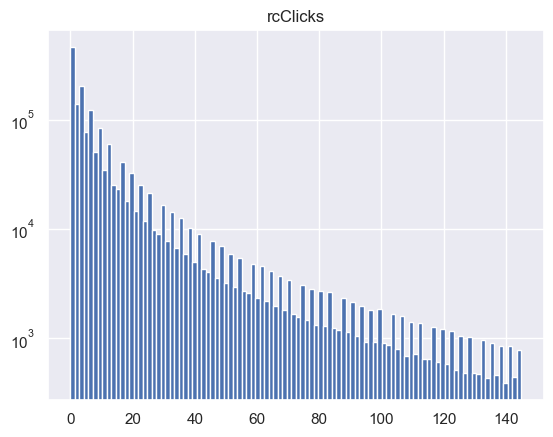

In [224]:
plt.figure(figsize=(10, 6))
combined_df.hist(column=['rcClicks'], bins= 100)
plt.yscale('log')


<Figure size 1000x600 with 0 Axes>

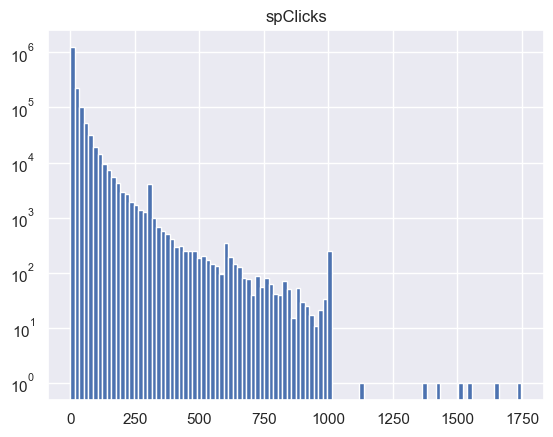

In [175]:
plt.figure(figsize=(10, 6))
combined_df.hist(column=['spClicks'], bins=100)
plt.yscale('log')


<Figure size 1000x600 with 0 Axes>

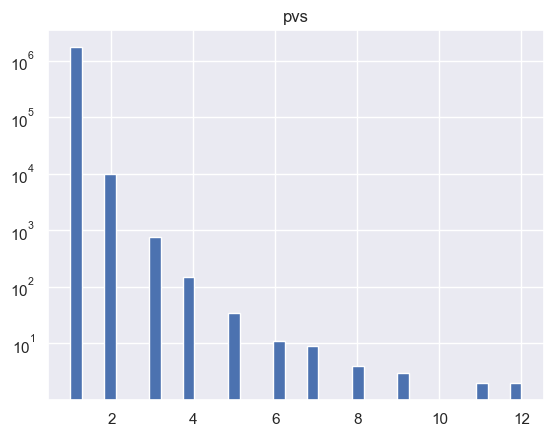

In [127]:
plt.figure(figsize=(10, 6))
combined_df.hist(column=['pvs'], bins=40)
plt.yscale('log')


In [223]:
combined_df["clicks"].value_counts()

0    1524509
1     167387
Name: clicks, dtype: int64

## handling outliers
In both spClicks and rcClicks there are clear outliers- a very small amount of samples with extremely large values.

In [176]:
z_score = zscore(combined_df['rcClicks'])

combined_df = combined_df[z_score <= 3.5]

<Figure size 1000x600 with 0 Axes>

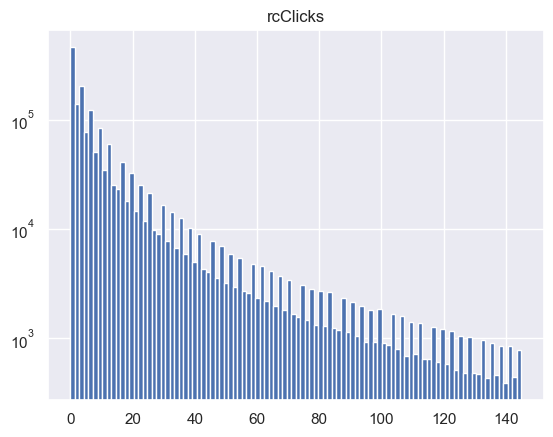

In [187]:
plt.figure(figsize=(10, 6))
combined_df.hist(column=['rcClicks'], bins= 100)
plt.yscale('log')


In [185]:
z_score_spClicks = zscore(combined_df['spClicks'])

combined_df = combined_df[z_score_spClicks <= 3.5]

<Figure size 1000x600 with 0 Axes>

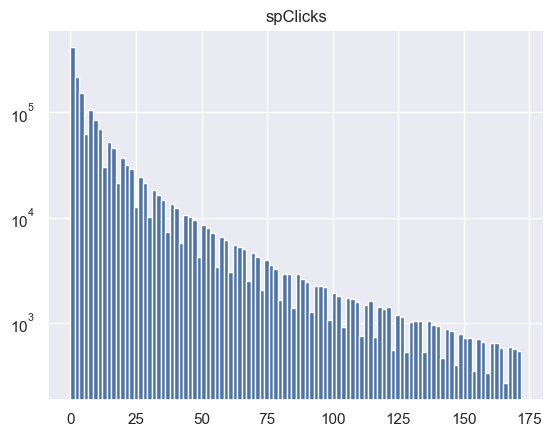

In [186]:
plt.figure(figsize=(10, 6))
combined_df.hist(column=['spClicks'], bins= 100)
plt.yscale('log')

# Limit Sparse Features

In [220]:
def limit_sparse_feature(feature_name, threshold):
    feature_counts = combined_df[feature_name].value_counts()

    values_to_replace = feature_counts[feature_counts < threshold].index

    combined_df[feature_name] = combined_df[feature_name].replace(values_to_replace, 'OTHER')


In [155]:
limit_sparse_feature("country", 10)

C:\Users\ofri\AppData\Local\Temp\ipykernel_2028\1593950919.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df[feature_name] = combined_df[feature_name].replace(values_to_replace, 'OTHER')


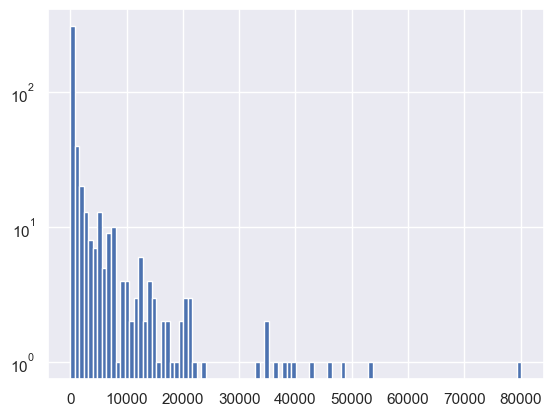

In [221]:
limit_sparse_feature('region', 20)
plt.figure()
region_value_counts = combined_df['region'].value_counts().values
plt.hist(region_value_counts, bins=100)
plt.yscale('log')

In [212]:
city_value_counts = combined_df['city'].value_counts()
sparse_values = city_value_counts[city_value_counts < 10].index
len(combined_df[combined_df['city'].isin(sparse_values)]) / len(combined_df)

Index(['bossoroca', 'algorta', 'petrosino', 'chabeuil', 'tibau do sul',
       'huttwil', 'kale', 'villabruna', 'sterling', 'beckdorf',
       ...
       'westborough', 'sainte-marie-du-mont', 'saulny', 'vernon hills', 'hode',
       'subotica', 'ljungby', 'serra da silveira', 'gerderest', 'sequals'],
      dtype='object', length=44344)


0.08721990004113728

In [234]:
df_exploded = combined_df['upperTaxonomy'].str.split('~', expand=True).stack().reset_index(level=1, drop=True).rename('Category')
# # Create a count plot using seaborn
# sns.set(style="darkgrid")
# plt.figure(figsize=(8, 6))
# sns.countplot(x=df_exploded, palette="viridis")

# # Show the plot
# plt.title('Distribution of Categories')
# plt.show()

# version

In [251]:
combined_df.to_csv("mid-processed-data.csv", index=False)

# Building First Model

### Dropping Irrelevant Features

In [315]:
data = combined_df

### Split Train Test

In [316]:
labels = data['clicks']
data = data.drop('clicks', axis=1)

In [317]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size= 0.2, random_state=42)

### Create And Fit Model

In [318]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691896 entries, 1758002 to 571747
Data columns (total 18 columns):
 #   Column              Dtype   
---  ------              -----   
 0   sourceItemId        int64   
 1   itemId              int64   
 2   placement           category
 3   userId              object  
 4   publisherId         object  
 5   publisherLanguage   category
 6   city                category
 7   region              category
 8   country             category
 9   sessionReferrer     category
 10  userQualityLoyalty  category
 11  upperTaxonomy       category
 12  alchemyTaxonomy     category
 13  rcClicks            float32 
 14  spClicks            float32 
 15  date                int32   
 16  pvs                 int32   
 17  session_depth       int32   
dtypes: category(9), float32(2), int32(3), int64(2), object(2)
memory usage: 157.6+ MB


In [337]:
model = CatBoostClassifier(depth=6,  learning_rate= 0.1, num_trees=200 , cat_features= ['placement', 'publisherLanguage', 'city', 'region', 'country', 'sessionReferrer', 'userQualityLoyalty', 'upperTaxonomy', 'alchemyTaxonomy', "userId", "publisherId", "sourceItemId", "itemId"])

In [338]:
model.fit(X_train, y_train)

0:	learn: 0.6060392	total: 1.9s	remaining: 6m 17s
1:	learn: 0.5399875	total: 6.04s	remaining: 9m 58s
2:	learn: 0.4884244	total: 8.19s	remaining: 8m 57s
3:	learn: 0.4478757	total: 10.9s	remaining: 8m 56s
4:	learn: 0.4180294	total: 13.6s	remaining: 8m 51s
5:	learn: 0.3961005	total: 14.6s	remaining: 7m 52s
6:	learn: 0.3770710	total: 17.3s	remaining: 7m 55s
7:	learn: 0.3622769	total: 21.2s	remaining: 8m 29s
8:	learn: 0.3506751	total: 25.3s	remaining: 8m 56s
9:	learn: 0.3414364	total: 27.5s	remaining: 8m 42s
10:	learn: 0.3335903	total: 30.1s	remaining: 8m 36s
11:	learn: 0.3281914	total: 32.1s	remaining: 8m 22s
12:	learn: 0.3236172	total: 35.7s	remaining: 8m 33s
13:	learn: 0.3198104	total: 39.2s	remaining: 8m 40s
14:	learn: 0.3166612	total: 42.5s	remaining: 8m 43s
15:	learn: 0.3139959	total: 45.5s	remaining: 8m 42s
16:	learn: 0.3119206	total: 48.9s	remaining: 8m 46s
17:	learn: 0.3100519	total: 51.9s	remaining: 8m 44s
18:	learn: 0.3087549	total: 54.9s	remaining: 8m 43s
19:	learn: 0.3074202	to

In [339]:
y_pred = model.predict(X_test)

In [340]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.901403747266387

100 trees, depth- 6 accuracy: 0.9010875347242745
200 trees, depth- 6 accuracy: 0.901403747266387

## Model V2

### Dropping Irrelevant Features

In [279]:
data_V2 = combined_df_v2.drop(['userId', 'publisherId', 'itemId', 'sourceItemId', 'date'], axis=1)
labels_V2 = data_V2['clicks']
data_V2 = data_V2.drop('clicks', axis=1)

### Split Train Test

In [281]:
X_train_V2, X_test_V2, y_train_V2, y_test_V2 = train_test_split(data_V2, labels_V2, test_size= 0.2, random_state=42)

### Create And Fit Model

In [299]:
cat_features_indices = ['placement', 'publisherLanguage', 'city', 'region', 'country', 'sessionReferrer', 'userQualityLoyalty', 'upperTaxonomy', 'alchemyTaxonomy']

In [304]:
model_V2 = CatBoostClassifier(iterations=30, depth=3, learning_rate= 0.1, cat_features= ['placement', 'publisherLanguage', 'city', 'region', 'country', 'sessionReferrer', 'userQualityLoyalty', 'upperTaxonomy', 'alchemyTaxonomy'])

In [305]:
model_V2.fit(X_train_V2, y_train_V2)

0:	learn: 0.6316216	total: 686ms	remaining: 19.9s
1:	learn: 0.5817498	total: 898ms	remaining: 12.6s
2:	learn: 0.5401440	total: 1.6s	remaining: 14.4s
3:	learn: 0.5055643	total: 1.97s	remaining: 12.8s
4:	learn: 0.4765570	total: 2.45s	remaining: 12.3s
5:	learn: 0.4521165	total: 2.72s	remaining: 10.9s
6:	learn: 0.4314439	total: 3.17s	remaining: 10.4s
7:	learn: 0.4139200	total: 3.52s	remaining: 9.68s
8:	learn: 0.3989454	total: 3.93s	remaining: 9.16s
9:	learn: 0.3862857	total: 4.35s	remaining: 8.7s
10:	learn: 0.3753567	total: 4.76s	remaining: 8.23s
11:	learn: 0.3659587	total: 5.3s	remaining: 7.95s
12:	learn: 0.3583830	total: 5.51s	remaining: 7.2s
13:	learn: 0.3515141	total: 5.95s	remaining: 6.8s
14:	learn: 0.3456411	total: 6.47s	remaining: 6.47s
15:	learn: 0.3406444	total: 6.89s	remaining: 6.03s
16:	learn: 0.3365242	total: 7.35s	remaining: 5.62s
17:	learn: 0.3328547	total: 7.77s	remaining: 5.18s
18:	learn: 0.3298238	total: 8.21s	remaining: 4.75s
19:	learn: 0.3272537	total: 8.56s	remaining: 4

In [306]:
y_pred_V2 = model_V2.predict(X_test_V2)


In [307]:
accuracy_V2 = accuracy_score(y_test_V2, y_pred_V2)
accuracy_V2

0.9010136532892015

## Visualize Feature Importance

In [324]:
feature_importance = model.get_feature_importance()
features = data.columns
for i, importance in enumerate(feature_importance):
    print(f"{features[i]}: Importance = {round(importance, 2)}")

sourceItemId: Importance = 0.0
itemId: Importance = 18.41
placement: Importance = 17.92
userId: Importance = 0.0
publisherId: Importance = 28.02
publisherLanguage: Importance = 0.27
city: Importance = 0.0
region: Importance = 0.06
country: Importance = 0.55
sessionReferrer: Importance = 0.01
userQualityLoyalty: Importance = 0.02
upperTaxonomy: Importance = 0.13
alchemyTaxonomy: Importance = 0.96
rcClicks: Importance = 32.64
spClicks: Importance = 1.01
date: Importance = 0.0
pvs: Importance = 0.0
session_depth: Importance = 0.0


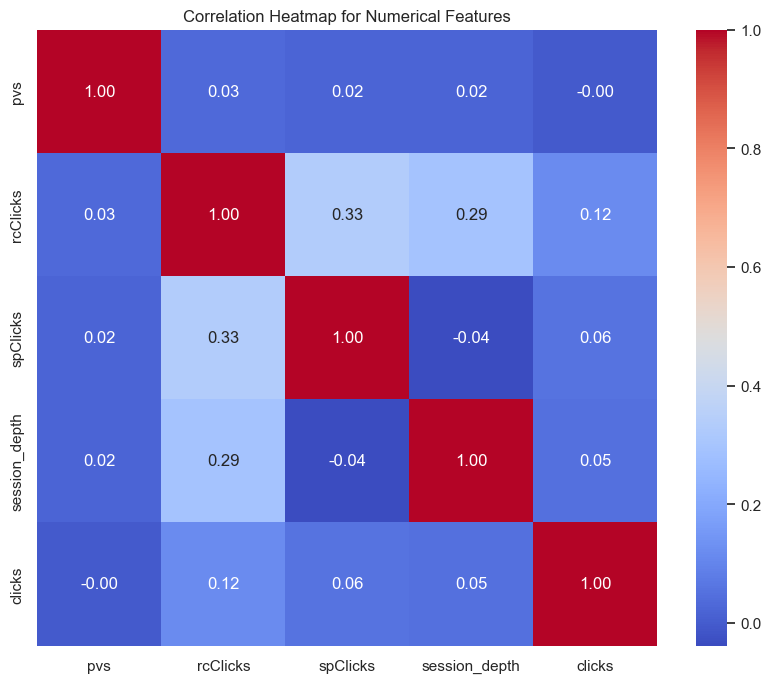

In [310]:
numerical_features = ["pvs", "rcClicks", "spClicks", "session_depth", "clicks"]
numerical_features_corr = combined_df[numerical_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(numerical_features_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for Numerical Features')
plt.show()